### Long-Short Equity Strategy using Ranking

https://medium.com/auquan/long-short-equity-trading-strategy-daa41d00a036

https://github.com/Auquan/Tutorials/blob/master/Long-Short%20Strategies%20using%20Ranking.ipynb

https://bitbucket.org/auquan/auquantoolbox/wiki/Home

Long-short equity strategy is both long and short stocks simulatenously in the market. The strategy rank all stocks in the market using some model and goes long (buys) the top  n  equities of the ranking, and short on (sells) the bottom  n  for equal amounts of money(Total value of long position = Total value of short position).

This is statistically robust - by ranking stocks and entering multiple positions, you are making many bets on your ranking model rather than just a few risky bets. You are also betting purely on the quality of your ranking scheme, as the equal dollar volume long and short positions ensure that the strategy will remain market neutral (immune to market movements).

Ranking Scheme
A ranking scheme is any model that can assign each stocks a number, where higher is better or worse. Examples could be value factors, technical indicators, pricing models, or a combination of all of the above. For example, you could use a momentum indicator to give a ranking to stocks, or combine two indicators like Score = (0.5 x the PE Ratio of that stock) + (0.5 x the 30 day price momentum)

The success of this strategy lies in the ranking scheme used - the returns of a long-short equity strategy are dependent on how well the ranking spreads out the high and low returns, so developing a ranking scheme is nontrivial.

Making a Bet on the Ranking Scheme
Once we have determined a ranking scheme, we would like to be able to profit from it. We do this by investing an equal amount of money long into the top of the ranking, and short into the bottom. This ensures that the strategy will make money proportionally to the quality of the ranking only, and will be market neutral.

Let's say you are ranking  m  equities, have  d  dollars to invest, and your total target number of positions to hold is  2n 
For each equity in spots  1,…,n  in the ranking, sell  12n∗d  dollars of that equity
For each equity in spots  m−n,…,m  in the ranking, buy  12n∗d  dollars of that equity.
Note: Friction Because of Prices Because equity prices will not always divide  12n∗d  evenly, and equities must be bought in integer amounts, there will be some imprecision and the algorithm should get as close as it can to this number. Most algorithms will have access to some leverage during execution, so it is fine to buy slightly more than  12n∗d  dollars per equity. This does, however, cause some friction at low capital amounts. For a strategy running  d=100000 , and  n=500 , we see that
12n∗d=11000∗100000=100
 
This will cause big problems for expensive equities, and cause the algorithm to be overlevered. This is alleviated by trading fewer equities or increasing the capital,  d .

Let's run through a hypothetical example
We generate random equite names and a random factor on which to rank them. We also assume our future returns are dependent on these factor values.

In [1]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
## PROBLEM SETUP ##
# Generate stocks and a random factor value for them
stock_names = ['stock ' + str(x) for x in range(10000)]
current_factor_values = np.random.normal(0, 1, 10000)
# Generate future returns for these are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)
# Put both the factor values and returns into one dataframe
data = pd.DataFrame(index = stock_names, columns=['Factor Value','Returns'])
data['Factor Value'] = current_factor_values
data['Returns'] = future_returns
# Take a look
data.head(10)

,Factor Value,Returns
stock 0,-0.287810,-1.021476
stock 1,1.473822,1.880652
stock 2,-0.987762,-0.069781
stock 3,0.149206,-0.196346
stock 4,0.102243,0.769588
stock 5,0.597321,0.763787
stock 6,-0.691898,-1.883518
stock 7,0.305637,0.015110
stock 8,1.822914,3.858180
stock 9,0.953899,0.587897


Now that we have factor values and returns, we can see what would happen if we ranked our equities based on factor values, and then entered the long and short positions.

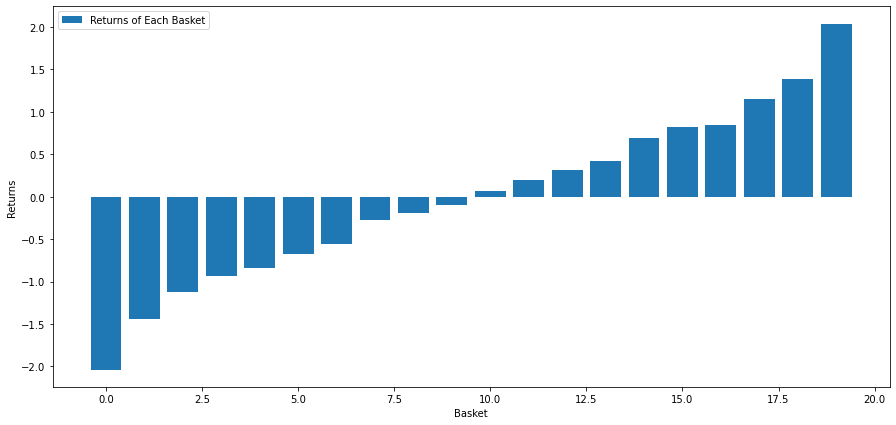

In [3]:
# Rank the equities
ranked_data = data.sort_values('Factor Value')

# Compute the returns of each basket with a basket size 500, so total (10000/500) baskets
number_of_baskets = int(10000/500)
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

Our strategy is to go long the top basket and short the bottom basket. The returns of this strategy are:

In [4]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.072340636650122

We're basically putting our money on our ranking model being able to separate and spread high performing stocks from low performing stocks. The nice thing about making money based on the spread of the ranking is that it is unaffected by what the market does.

**Let's now consider a real world example**.<br>
We load data for 30 stocks from different sectors in S&P500 and try to rank them, we will use price based indicators for ranking.

https://github.com/ranaroussi/yfinance

https://pypi.org/project/yfinance/

In [6]:
#from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime
from pandas_datareader import data as pdr
import yfinance as yf

#startDateStr = '2010/01/01'
#endDateStr = '2018/12/31'
#cachedFolderName = 'yahooData/'
#dataSetId = 'testLongShortTrading'
instrumentIds = ['ABT','BAC','AMGN','AMD','BSX',
                'CVS','DIS','EA','EOG','GLW','HAL',
                'HD','KO','LLY','MCD','MET','NEM',
                'PEP']

yf.pdr_override() # <== that's all it takes :-)

# download dataframe
ds = pdr.get_data_yahoo(instrumentIds, start="2016-01-01", end="2019-12-31")

#ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
#                            dataSetId=dataSetId,
#                            instrumentIds=instrumentIds,
#                            startDateStr=startDateStr,
#                            endDateStr=endDateStr,
#                            event='history')

price = 'Adj Close'

[*********************100%***********************]  18 of 18 completed


Let's start by using one month normalized Momentum as a ranking indicator

In [7]:
ds.head()

Adj Close                                                     \
                  ABT   AMD        AMGN        BAC        BSX        CVS   
Date                                                                       
2015-12-31  40.715683  2.87  142.107895  15.348064  18.440001  85.289619   
2016-01-04  38.920612  2.77  138.614960  14.983289  17.990000  84.146851   
2016-01-05  38.911533  2.75  138.466080  14.983289  18.180000  84.391106   
2016-01-06  38.585155  2.51  137.196777  14.664108  18.000000  83.361740   
2016-01-07  37.660427  2.28  133.922638  14.135177  17.639999  82.157898   

                                                        ...     Volume  \
                  DIS         EA        EOG        GLW  ...        EOG   
Date                                                    ...              
2015-12-31  99.137009  68.720001  66.413841  16.171160  ...  3117300.0   
2016-01-04  97.155785  66.099998  65.372459  15.843846  ...  5136700.0   
2016-01-05  95.193428  64.940002  65.794647  15.835000  ...  3665200.0   
2016-01-06  94.683952  63.680000  63.158352  15.481143  ...  6626700.0   
2016-01-07  93.872604  62.459999  61.413342  15.127291  ...  5297900.0   

                                                                       \
                   GLW         HAL          HD          KO        LLY   
Date                                                                    
2015-12-31   7590100.0   6194500.0   3178700.0   9727900.0  3178500.0   
2016-01-04  10840700.0  10032900.0   8050900.0  16084100.0  6907300.0   
2016-01-05  11931400.0   8100900.0   5320900.0  15781900.0  7475300.0   
2016-01-06  12620500.0  12337000.0   8199600.0  16245100.0  6628400.0   
2016-01-07  11555100.0  11050900.0  12551000.0  20563600.0  5833200.0   

                                                          
                  MCD         MET         NEM        PEP  
Date                                                      
2015-12-31  3723200.0   4618600.0   4189200.0  3041500.0  
2016-01-04  9995000.0   8890700.0   6578900.0  6689000.0  
2016-01-05  6314000.0   9564600.0   5330800.0  4893800.0  
2016-01-06  6543800.0  15277200.0   6273200.0  5483400.0  
2016-01-07  7477900.0  15733600.0  12351400.0  5440000.0  

[5 rows x 108 columns]

In [8]:
## Load relevant prices in a dataframe
#data = ds.getBookDataByFeature()["adjClose"]
#data = ds.columns()["adjClose"]
data = ds["Adj Close"]
data.tail()

,ABT,AMD,AMGN,BAC,BSX,CVS,DIS,EA,EOG,GLW,HAL,HD,KO,LLY,MCD,MET,NEM,PEP
Date,,,,,,,,,,,,,,,,,,
2019-12-23,85.994247,45.459999,238.099670,34.464893,45.220001,72.088829,144.679993,107.790001,80.899864,28.402168,24.469522,215.325104,53.509411,129.232437,192.561874,49.227913,41.316673,134.108109
2019-12-24,85.925331,46.540001,237.413879,34.513897,45.310001,72.214836,145.289993,108.550003,81.317070,28.109560,24.440031,216.759232,53.314514,129.193024,193.023178,49.227913,41.722218,133.961319
2019-12-26,85.925331,46.630001,236.992599,34.807880,45.259998,72.185768,145.699997,108.510002,81.161842,28.314386,24.125439,216.906586,53.616611,129.222580,193.405945,49.469273,42.226681,133.765625
2019-12-27,86.043480,46.180000,236.630112,34.641285,45.220001,72.108223,145.750000,108.430000,80.667007,28.080301,23.987801,216.071625,53.938194,129.597031,194.495361,49.073444,42.246464,134.597427
2019-12-30,85.452782,45.520000,235.395676,34.445301,44.990002,71.429779,143.770004,106.930000,79.939316,28.294878,24.145098,213.458755,53.860233,129.380234,193.258728,48.947933,43.275181,133.883041


In [9]:
def momentum(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0) / dataDf.iloc[-1]

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [10]:
#Let's load Momentum score and returns into separate dataframes
index = data.index
mscores = pd.DataFrame(index=index,columns=instrumentIds) # assetList
mscores = momentum(data, 30)
returns = pd.DataFrame(index=index,columns=instrumentIds) # assetList
day = 30

Analyzing data
Stock behavior
We look at how our chosen basket of stocks behave w.r.t our ranking model. Below we look at the correlation of 1 week forward return with momentum for every stock

In [11]:
# Calculate Forward returns
forward_return_day = 5
returns = data.shift(-forward_return_day)/data -1
returns.dropna(inplace = True)

          Scores      pvalues
MET    -0.134985  1.84495e-05
EOG    -0.128965  4.30936e-05
BAC    -0.127299  5.41491e-05
GLW   -0.0988058   0.00175844
ABT   -0.0857539   0.00665996
KO     -0.064005    0.0430155
PEP   -0.0606064    0.0553768
AMD   -0.0596601    0.0593031
CVS   -0.0587115    0.0634678
HD    -0.0568532    0.0723257
AMGN  -0.0516346     0.102706
DIS     -0.05039     0.111275
LLY   -0.0490834     0.120867
MCD  -0.00921319      0.77106
BSX   0.00114359     0.971188
NEM   0.00281067     0.929265
HAL    0.0166468     0.599029
EA     0.0243384     0.442013


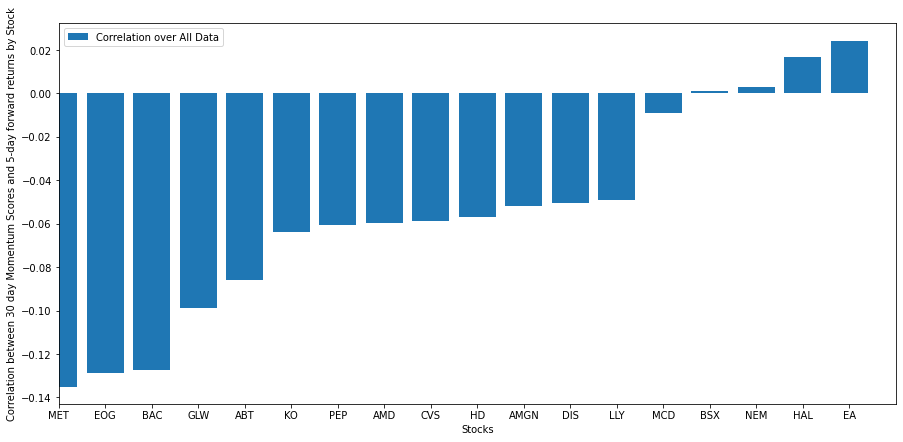

In [12]:
# Calculate correlations between momentum and returns
correlations = pd.DataFrame(index = returns.columns, columns = ['Scores', 'pvalues'])
mscores = mscores[mscores.index.isin(returns.index)]
for i in correlations.index:
    score, pvalue = stats.spearmanr(mscores[i], returns[i])
    correlations['pvalues'].loc[i] = pvalue
    correlations['Scores'].loc[i] = score
correlations.dropna(inplace = True)
correlations.sort_values('Scores', inplace=True)
print(correlations)
l = correlations.index.size
plt.figure(figsize=(15,7))
plt.bar(range(1,1+l),correlations['Scores'])
plt.xlabel('Stocks')
plt.xlim((1, l+1))
plt.xticks(range(1,1+l), correlations.index)
plt.legend(['Correlation over All Data'])
plt.ylabel('Correlation between %s day Momentum Scores and %s-day forward returns by Stock'%(day,forward_return_day));
plt.show()

All our stocks are mean reverting to some degree! (Obviously we choose the universe to be this way :) )

This tells us that if a stock ranks high on momentum score, we should expect it to perform poorly next week.

Correlation between score and returns
Next, we need to look at correlation between our ranking score and forward returns, i.e. how predictive of of forward returns is our ranking factor?

To do this, we calculate daily correlation between 30 day momentum and 1 week forward returns of all stocks

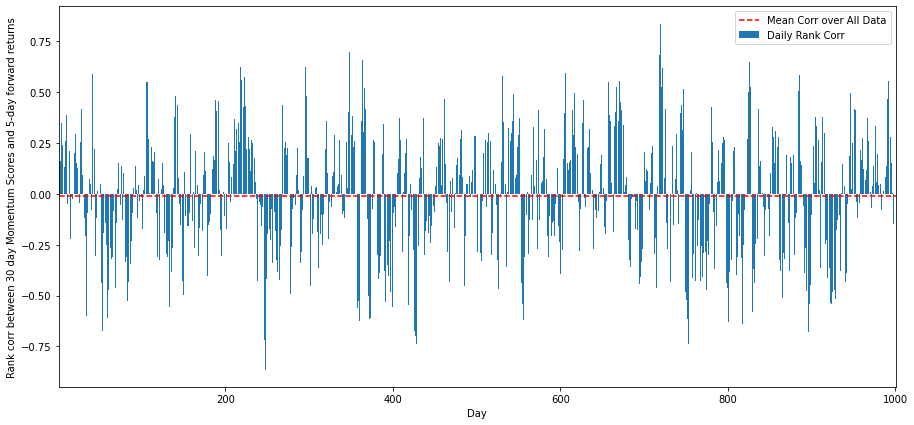

In [13]:
# 
correl_scores = pd.DataFrame(index = returns.index.intersection(mscores.index), columns = ['Scores', 'pvalues'])
for i in correl_scores.index:
    score, pvalue = stats.spearmanr(mscores.loc[i], returns.loc[i])
    correl_scores['pvalues'].loc[i] = pvalue
    correl_scores['Scores'].loc[i] = score
correl_scores.dropna(inplace = True)    

l = correl_scores.index.size
plt.figure(figsize=(15,7))
plt.bar(range(1,1+l),correl_scores['Scores'])
plt.hlines(np.mean(correl_scores['Scores']), 1,l+1, colors='r', linestyles='dashed')
plt.xlabel('Day')
plt.xlim((1, l+1))
plt.legend(['Mean Corr over All Data', 'Daily Rank Corr'])
plt.ylabel('Rank corr between %s day Momentum Scores and %s-day forward returns'%(day,forward_return_day));
plt.show()

Daily Correlation is quite noisy, but very slightly negative (This is expected, since we said all the stocks are mean reverting). Let's also look at average monthly correlation of scores with 1 month forward returns

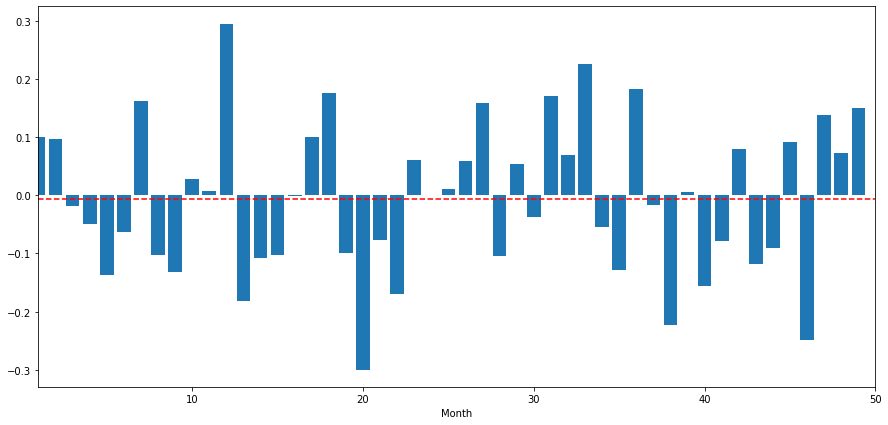

In [14]:
monthly_mean_correl =correl_scores['Scores'].astype(float).resample('M').mean()
plt.figure(figsize=(15,7))
plt.bar(range(1,len(monthly_mean_correl)+1), monthly_mean_correl)
plt.hlines(np.mean(monthly_mean_correl), 1,len(monthly_mean_correl)+1, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, len(monthly_mean_correl)+1))
#plt.legend(['Mean Correlation over All Data', 'Monthly Rank Correlation'])
#plt.ylabel('Rank correlation between %s day Momentum Scores and %s-day forward returns'%(day,forward_return_day));
plt.show()

We can see that the average correlation is slightly negative againt, but varies a lot daily as well from month to month.

Average Basket Return
Now we compute the returns of baskets taken out of our ranking. If we rank all equities and then split them into  n  groups, what would the mean return be of each group?

The first step is to create a function that will give us the mean return in each basket in a given the month and a ranking factor.

In [15]:
def compute_basket_returns(factor, forward_returns, number_of_baskets, index):

    data = pd.concat([factor.loc[index],forward_returns.loc[index]], axis=1)
    # Rank the equities on the factor values
    data.columns = ['Factor Value', 'Forward Returns']
    data.sort_values('Factor Value', inplace=True)
    # How many equities per basket
    equities_per_basket = np.floor(len(data.index) / number_of_baskets)

    basket_returns = np.zeros(number_of_baskets)

    # Compute the returns of each basket
    for i in range(number_of_baskets):
        start = i * equities_per_basket
        if i == number_of_baskets - 1:
            # Handle having a few extra in the last basket when our number of equities doesn't divide well
            end = len(data.index) - 1
        else:
            end = i * equities_per_basket + equities_per_basket
        # Actually compute the mean returns for each basket
        #s = data.index.iloc[start]
        #e = data.index.iloc[end]
        basket_returns[i] = data.iloc[int(start):int(end)]['Forward Returns'].mean()
        
    return basket_returns

We calculate the average return of each basket when equities are ranked based on this score. This should give us a sense of the relationship over a long timeframe.

[0.00101334 0.00044771 0.00084431 0.00061784 0.00107891 0.00145146
 0.00049373 0.00056619]


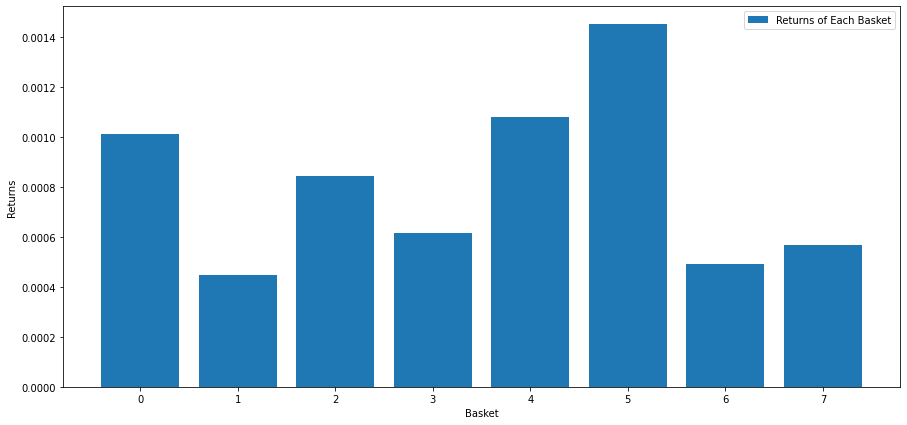

In [16]:
number_of_baskets = 8
mean_basket_returns = np.zeros(number_of_baskets)
resampled_scores = mscores.astype(float).resample('2D').last()
resampled_prices = data.astype(float).resample('2D').last()
resampled_scores.dropna(inplace=True)
resampled_prices.dropna(inplace=True)
forward_returns = resampled_prices.shift(-1)/resampled_prices -1
forward_returns.dropna(inplace = True)

for m in forward_returns.index.intersection(resampled_scores.index):
    basket_returns = compute_basket_returns(resampled_scores, forward_returns, number_of_baskets, m)
    mean_basket_returns += basket_returns

mean_basket_returns /= l    
print(mean_basket_returns)
# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), mean_basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

Seems like we are able to separate high performers from low performers with very small success

Spread Consistency
Of course, that's just the average relationship. To get a sense of how consistent this is, and whether or not we would want to trade on it, we should look at it over time. Here we'll look at the monthly spreads for the first two years. We can see a lot of variation, and further analysis should be done to determine whether this momentum score is tradeable.

C:\Users\alber\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


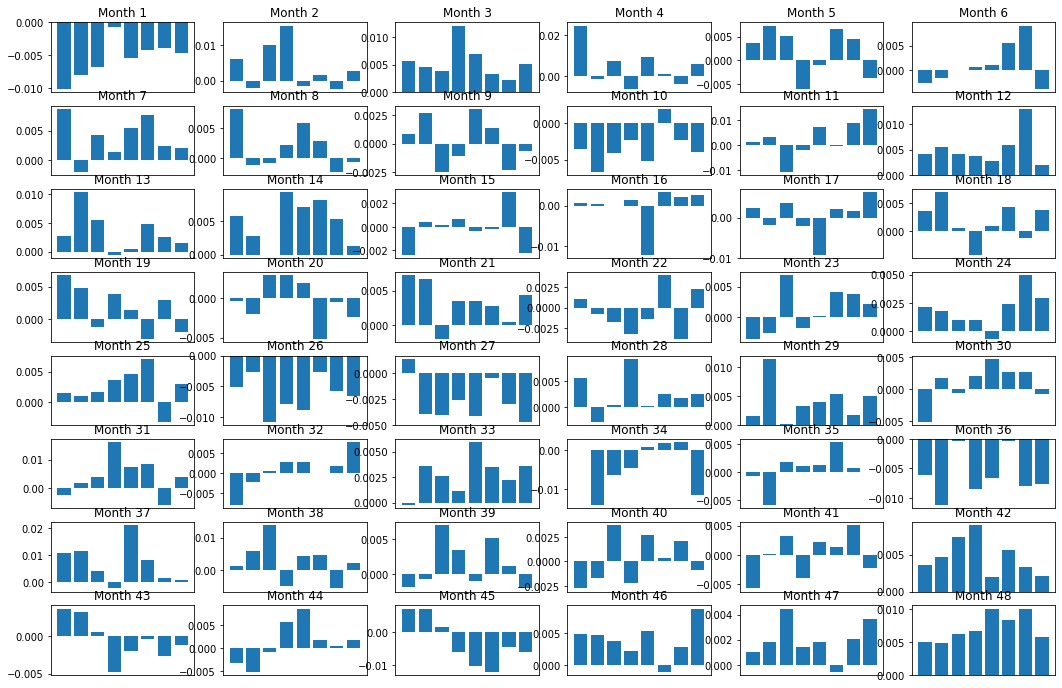

In [17]:
total_months = mscores.resample('M').last().index
months_to_plot = total_months.size
monthly_index = total_months[:months_to_plot]
mean_basket_returns = np.zeros(number_of_baskets)
strategy_returns = pd.Series(index = monthly_index)
f, axarr = plt.subplots(int(monthly_index.size/6), 6,figsize=(18, 12))
for month in range(1, monthly_index.size):
    temp_returns = forward_returns.loc[monthly_index[month-1]:monthly_index[month]]
    temp_scores = resampled_scores.loc[monthly_index[month-1]:monthly_index[month]]
    for m in temp_returns.index.intersection(temp_scores.index):
        basket_returns = compute_basket_returns(temp_scores, temp_returns, number_of_baskets, m)
        mean_basket_returns += basket_returns
    
    strategy_returns[monthly_index[month-1]] = mean_basket_returns[ number_of_baskets-1] - mean_basket_returns[0]
    
    mean_basket_returns /= temp_returns.index.intersection(temp_scores.index).size
    
    r = int(np.floor((month-1) / 6))
    c = (month-1) % 6
    axarr[r, c].bar(range(number_of_baskets), mean_basket_returns)#
    axarr[r, c].xaxis.set_visible(False)
    axarr[r, c].set_title('Month ' + str(month))
plt.show()

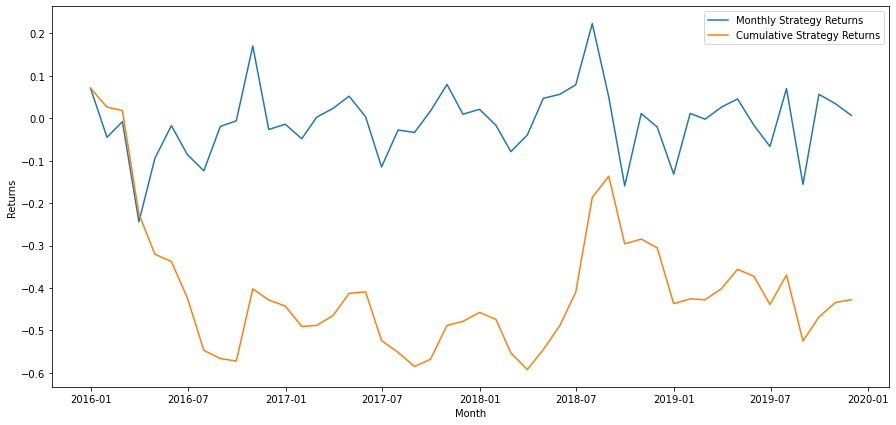

In [18]:
plt.figure(figsize=(15,7))
plt.plot(strategy_returns)
plt.ylabel('Returns')
plt.xlabel('Month')
plt.plot(strategy_returns.cumsum())
plt.legend(['Monthly Strategy Returns','Cumulative Strategy Returns'])
plt.show()

Finally, lets look at the returns if we had bought the last basket and sold the first basket every month (assuming equal capital allocation to each security)

In [19]:
total_return = strategy_returns.sum()
ann_return = 100*((1 + total_return)**(12.0 /float(strategy_returns.index.size))-1)
print('Annual Returns: %.2f%%'%ann_return)

Annual Returns: -12.76%


Finding the correct ranking scheme
To execute a long-short equity, you effectively only have to determine the ranking scheme. Everything after that is mechanical. Once you have one long-short equity strategy, you can swap in different ranking schemes and leave everything else in place. It's a very convenient way to quickly iterate over ideas you have without having to worry about tweaking code every time.

The ranking schemes can come from pretty much any model as well. It doesn't have to be a value based factor model, it could be a machine learning technique that predicted returns one-month ahead and ranked based on that.

Choice and Evaluation of a Ranking Scheme
The ranking scheme is where a long-short equity strategy gets its edge, and is the most crucial component. Choosing a good ranking scheme is the entire trick, and there is no easy answer. A good starting point is to pick existing known techniques, and see if you can modify them slightly to get increased returns. We'll discuss a few starting points here.

Clone and Tweak Choose one that is commonly discussed and see if you can modify it slightly to gain back an edge. Often times factors that are public will have no signal left as they have been completely arbitraged out of the market. However, sometimes they lead you in the right direction of where to go.

Pricing Models Any model that predicts future returns can be a factor. The future return predicted is now that factor, and can be used to rank your universe. You can take any complicated pricing model and transform it into a ranking.

Price Based Factors (Technical Indicators) Price based factors take information about the historical price of each equity and use it to generate the factor value. Examples could be 30-day momentum, or volatility measures. 
Reversion vs. Momentum It's important to note that some factors bet that prices, once moving in a direction, will continue to do so. Some factors bet the opposite. Both are valid models on different time horizons and assets, and it's important to investigate whether the underlying behavior is momentum or reversion based.

Fundamental Factors (Value Based) This is using combinations of fundamental values as we discussed today. Fundamental values contain information that is tied to real world facts about a company, so in many ways can be more robust than prices.

The Arms Race Ultimately, developing predictive factors is an arms race in which you are trying to stay one step ahead. Factors get arbitraged out of markets and have a lifespan, so it's important that you are constantly doing work to determine how much decay your factors are experiencing, and what new factors might be used to take their place.

Additional Considerations
Rebalancing Frequency
Every ranking system will be predictive of returns over a slightly different timeframe. A price-based mean reversion may be predictive over a few days, while a value-based factor model may be predictive over many months. It is important to determine the timeframe over which your model should be predictive, and statistically verify that before executing your strategy. You dont want to overfit by trying to optimize the relabancing frequency - you will inevitably find one that is randomly better than others, but not necessary because of anything in your model.

Once you have determined the timeframe on which your ranking scheme is predictive, try to rebalance at about that frequency so you're taking full advantage of your models.

Capital Capacity and Transaction Costs
Every strategy has a minimum and maximum amount of capital it can trade before it stops being profitable.

Trading many equities will result in high transaction costs. Say that you want to purchase  1000  equities, you will incur thousands of dollars of costs per rebalance. Your capital base must be high enough that the transaction costs are a small percentage of the returns being generated by your strategy. Say that you are running  100,000  dollars and making  1%  per month, then the  1000  dollars of transaction fees per month would take up your all of returns. You would need to be running the strategy on millions of dollars for it to be profitable over  1000  equities.

The minimum capacity is quite high as such, and dependent largely on the number of equities traded. However, the maximum capacity is also incredibly high, with long-short equity strategies capable of trading hundreds of millions of dollars without losing their edge. This is true because the strategy rebalances relatively infrequently, and the total dollar volume is divided by the number of equities traded. So if you turn over your entire portfolio of  100,000,000  every month while running 1000 equities, you are only running  100,000  dollar-volume per month through each equity, which isn't enough to be a significant market share for most securities.